This is a notebook to examine the modeling to answer the problem of assiging a genre to a song based on Spotify
metadata of a song.

Imports

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F

Read in clean data

In [32]:
data = pd.read_csv('./data/clean_data.csv')

data.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,...,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_3,time_signature_4,time_signature_5,mode_1
0,0.831,0.814,-7.364,0.4200,0.0598,0.013400,0.0556,0.3890,156.985,2Vc6NJ9PW9gD9q343XFRKx,...,0,0,0,0,0,0,0,1,0,1
1,0.719,0.493,-7.230,0.0794,0.4010,0.000000,0.1180,0.1240,115.080,7pgJBLVz5VmnL7uGHmRj6p,...,0,0,1,0,0,0,0,1,0,1
2,0.850,0.893,-4.783,0.0623,0.0138,0.000004,0.3720,0.0391,218.050,0vSWgAlfpye0WCGeNmuNhy,...,0,0,0,0,0,0,0,1,0,1
3,0.476,0.781,-4.710,0.1030,0.0237,0.000000,0.1140,0.1750,186.948,0VSXnJqQkwuH2ei1nOQ1nu,...,0,0,0,0,0,0,1,0,0,1
4,0.798,0.624,-7.668,0.2930,0.2170,0.000000,0.1660,0.5910,147.988,4jCeguq9rMTlbMmPHuO7S3,...,0,0,0,0,0,0,0,1,0,1


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42305 entries, 0 to 42304
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   danceability          42305 non-null  float64
 1   energy                42305 non-null  float64
 2   loudness              42305 non-null  float64
 3   speechiness           42305 non-null  float64
 4   acousticness          42305 non-null  float64
 5   instrumentalness      42305 non-null  float64
 6   liveness              42305 non-null  float64
 7   valence               42305 non-null  float64
 8   tempo                 42305 non-null  float64
 9   id                    42305 non-null  object 
 10  duration_ms           42305 non-null  int64  
 11  genre                 42305 non-null  int64  
 12  song_name             42299 non-null  object 
 13  song_name_char_count  42305 non-null  int64  
 14  song_name_word_count  42305 non-null  int64  
 15  key_1              

In [34]:
X = data.drop(columns=['id','genre', 'song_name'])
y = np.array(data['genre'])

type(y)
y

array([ 0,  0,  0, ..., 14, 14, 14], dtype=int64)

Split data into training and testing datasets

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)



y_train


array([12,  9,  9, ..., 13,  0,  4], dtype=int64)

In [36]:
X_train_t = torch.tensor(X_train_sc).float()
y_train_t = torch.tensor(y_train).long()

X_test_t = torch.tensor(X_test_sc).float()
y_test_t = torch.tensor(y_test).long()
y_train_t

tensor([12,  9,  9,  ..., 13,  0,  4])

In [37]:
class MultiClassModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(27, 32)
        self.h2 = nn.Linear(32, 64)
        self.h3 = nn.Linear(64, 64)
        self.h4 = nn.Linear(64, 128)
        self.h5 = nn.Linear(128, 128)
        #self.h6 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 15)

    def forward(self, X):
        X = F.relu(self.h1(X))
        X = F.relu(self.h2(X))
        X = F.relu(self.h3(X))
        X = F.relu(self.h4(X))
        X = F.relu(self.h5(X))
        #X = F.relu(self.h6(X))
        return self.out(X)


model = MultiClassModel()

loss_fn = nn.CrossEntropyLoss()

Create your `torch.optim.Adam()` optimizer.

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [39]:
train_loss = []
testing_loss = []
train_accuracy = []
test_accuracy = []
batch_size = 512
training_size = X.shape[0]
for epoch in range(150):
    with torch.no_grad():
        test_pred = model(X_test_t)
        test_loss = loss_fn(test_pred,y_test_t)
        testing_loss.append(test_loss.item())
        train_pred = model(X_train_t)
        loss = loss_fn(train_pred, y_train_t)
        train_loss.append(loss.item())
        train_accuracy.append((train_pred.argmax(axis=1) == y_train_t).float().mean())
        test_accuracy.append((test_pred.argmax(axis=1) == y_test_t).float().mean())
    for batch_idx in range(0, training_size, batch_size):
        # zero out the optimizer's gradients
        optimizer.zero_grad()

        # Create X_batch and y_batch
        X_batch = X_train_t[batch_idx:batch_idx + batch_size]
        y_batch = y_train_t[batch_idx:batch_idx + batch_size]

        # get predictions and loss
        pred = model(X_batch)

        loss = loss_fn(pred, y_batch)
        # back propagate
        loss.backward()

        # step
        optimizer.step()

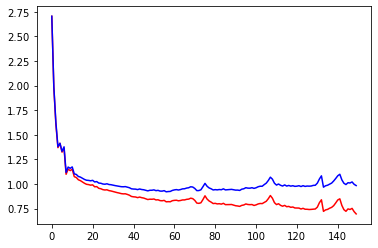

In [40]:
plt.plot(train_loss, color='red')
plt.plot(testing_loss, color= 'blue')

How did our model do?

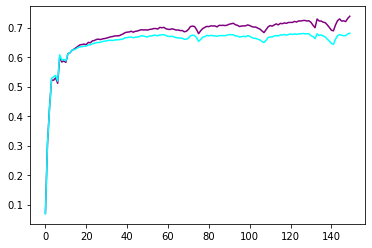

In [41]:
plt.plot(train_accuracy, color= 'purple')
plt.plot(test_accuracy, color= 'cyan')

In [42]:
# with torch.no_grad():
#     pred = model(X_test_t)
# (pred.argmax(axis=1) == y_test_t).float().mean()


